In [6]:
import role_permissions as rp
import pandas as pd
import pm4py

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

In [7]:
# Data Import:
xes_path = "/Users/moritz_hawener/Documents/Work/Studium/Master/WS25/BPI/BPI Challenge 2017_1_all/BPI Challenge 2017.xes.gz"

# Read the XES log
event_log = xes_importer.apply(xes_path)

parsing log, completed traces :: 100%|██████████| 31509/31509 [00:28<00:00, 1111.67it/s]


In [8]:
# Transform the event log to a pandas DataFrame
df = log_converter.apply(event_log, variant=log_converter.Variants.TO_DATA_FRAME)

Step 1: Discovering organizational roles...
Found 149 resources and 26 activities

Step 2: Evaluating cluster sizes...
Cophenetic correlation: 0.8790 (closer to 1 = better dendrogram fit)


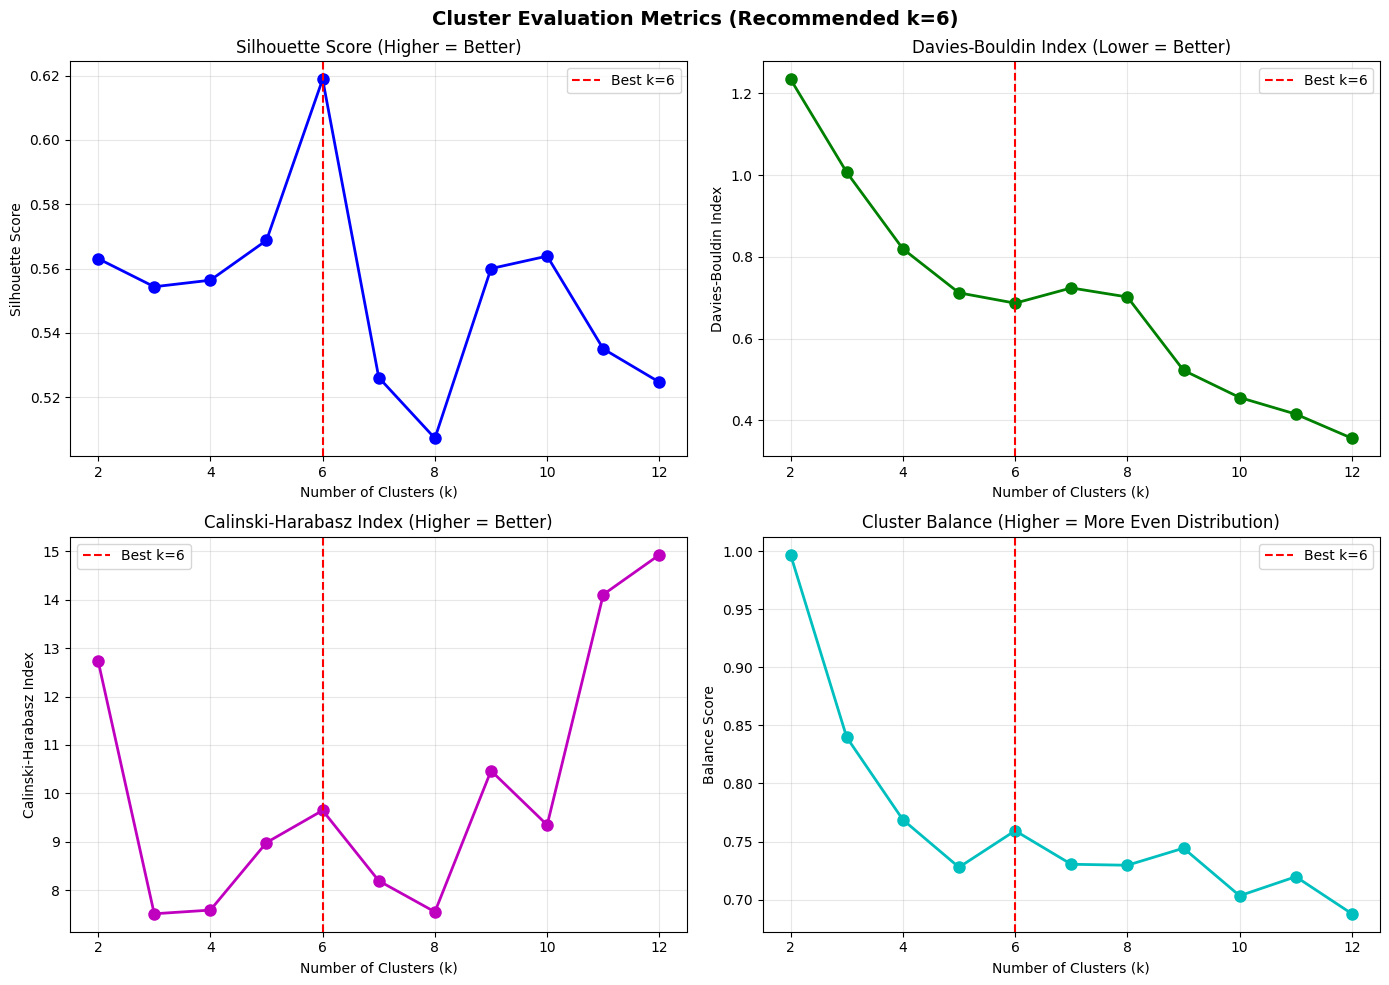


CLUSTER EVALUATION RESULTS
 k  silhouette  davies_bouldin  calinski_harabasz  balance_score
 2    0.563104        1.234348          12.737914       0.996805
 3    0.554361        1.006679           7.510614       0.839677
 4    0.556393        0.819451           7.586693       0.768797
 5    0.568773        0.711808           8.982424       0.727869
 6    0.618844        0.686497           9.646390       0.759342
 7    0.526139        0.723783           8.191681       0.730471
 8    0.507259        0.701629           7.549549       0.729620
 9    0.560008        0.522162          10.466590       0.744311
10    0.563880        0.455671           9.345535       0.703356
11    0.535037        0.415039          14.108671       0.719754
12    0.524690        0.355901          14.929965       0.687853

RECOMMENDED: k = 6 clusters

Step 3: Generating clusters with optimal k=6...

Cluster composition:
  Cluster 1: 12 activities
    - A_Accepted
    - A_Complete
    - O_Create Offer
    - O_Cr

In [9]:
# Run cluster evaluation
from cluster_evaluation import run_full_evaluation                                                                                                  
                                                                                                                                                      
# With your loaded DataFrame:                                                                                                                       
results = run_full_evaluation(df, min_k=2, max_k=12)  

In [4]:
# 1. Roles & Clustering
activity_clusters, resource_allocation_df, Z = rp.discover_roles(df)

# 2. Resource Assignment
resource_groups = rp.assign_resources_to_clusters(activity_clusters, resource_allocation_df, df)

Discovering organizational roles...
Assigning resources to clusters...


In [5]:
# Role Names Mapping (Could be externalized)
role_names = {
    1: "Core Process Handler",
    2: "Completion Specialist", 
    3: "Submission Handler",
    4: "Support & Communication Specialist",
    5: "Collections Specialist"
}

In [6]:
# 4. Context Definition
df = rp.define_execution_contexts(df, activity_clusters, resource_groups)

Defining execution contexts...


In [7]:
# 5. Capabilities
capabilities = rp.calculate_capabilities(df, resource_groups, role_names)

Calculating capabilities...


In [8]:
# 6. Build Model
organizational_model = rp.build_organizational_model(resource_groups, capabilities)

In [9]:
# 7. Generate simple permission map for backward compatibility
simple_permission_map = {}

for activity, cluster_id in activity_clusters.items():
    simple_permission_map[activity] = resource_groups[cluster_id]


In [10]:
# 7b. Context-aware permission map (OrdinoR - THE IMPORTANT ONE!)
context_permission_map = rp.generate_context_permission_map(
    df,
    organizational_model, 
    activity_clusters
)

Generating context permission map...


In [11]:
context_permission_map

defaultdict(list,
            {('A_Create Application', 'Very Complex', 'Morning'): ['User_1',
              'User_17',
              'User_52',
              'User_11',
              'User_117',
              'User_2',
              'User_38',
              'User_119',
              'User_30',
              'User_68',
              'User_19',
              'User_116',
              'User_101',
              'User_34',
              'User_31',
              'User_90',
              'User_89',
              'User_15',
              'User_16',
              'User_12',
              'User_3',
              'User_102',
              'User_114',
              'User_118',
              'User_95',
              'User_8',
              'User_113',
              'User_100',
              'User_28',
              'User_27',
              'User_99',
              'User_112',
              'User_75',
              'User_21',
              'User_87',
              'User_20',
              'User_43'

In [12]:
# 8. Save
rp.save_output(simple_permission_map, activity_clusters, resource_groups, 
                role_names, organizational_model, context_permission_map)
print("Process complete.")

Saving output files...
Saved organizational_model.pkl
Saved organizational_model.json
Saved context_permissions.csv (401 contexts)
Saved role_summary.csv

Export Summary:
   Simple permissions: 26 activities
   Context permissions: 401 contexts
   Resource groups: 5 clusters
   Total resources: 149 resources
Process complete.


In [13]:
activity_clusters

A_Accepted                    1
A_Complete                    1
O_Create Offer                1
O_Created                     1
O_Sent (mail and online)      1
W_Complete application        1
A_Cancelled                   1
A_Concept                     1
A_Create Application          1
W_Handle leads                1
O_Sent (online only)          1
W_Call after offers           1
W_Shortened completion        2
A_Submitted                   3
A_Pending                     4
O_Accepted                    4
W_Call incomplete files       4
W_Validate application        4
O_Cancelled                   4
O_Returned                    4
A_Incomplete                  4
W_Assess potential fraud      4
A_Validating                  4
O_Refused                     4
A_Denied                      4
W_Personal Loan collection    5
Name: cluster, dtype: int32

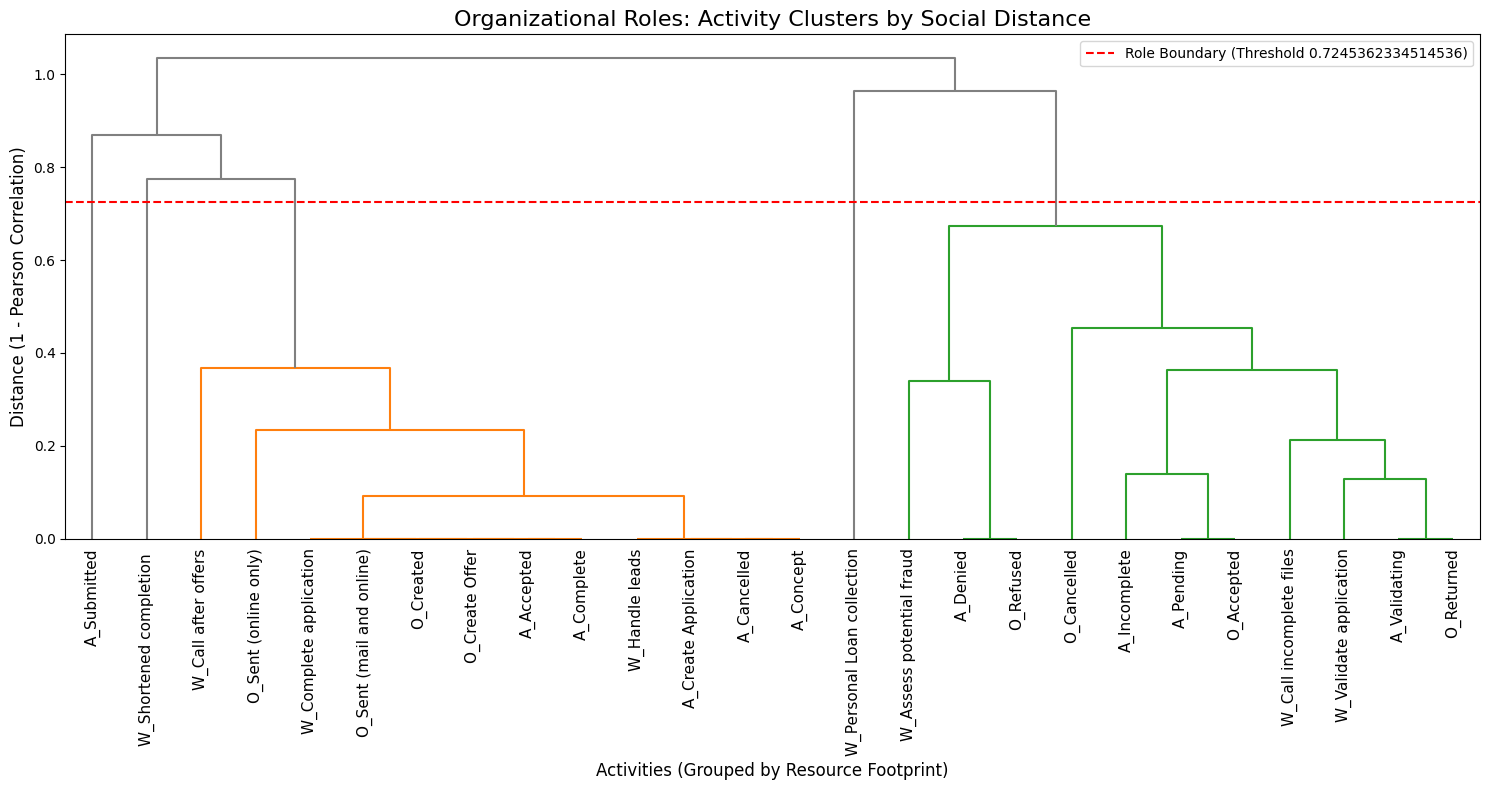

In [14]:
# Usage:
rp.plot_colored_dendrogram(Z, activity_clusters, resource_allocation_df.columns)

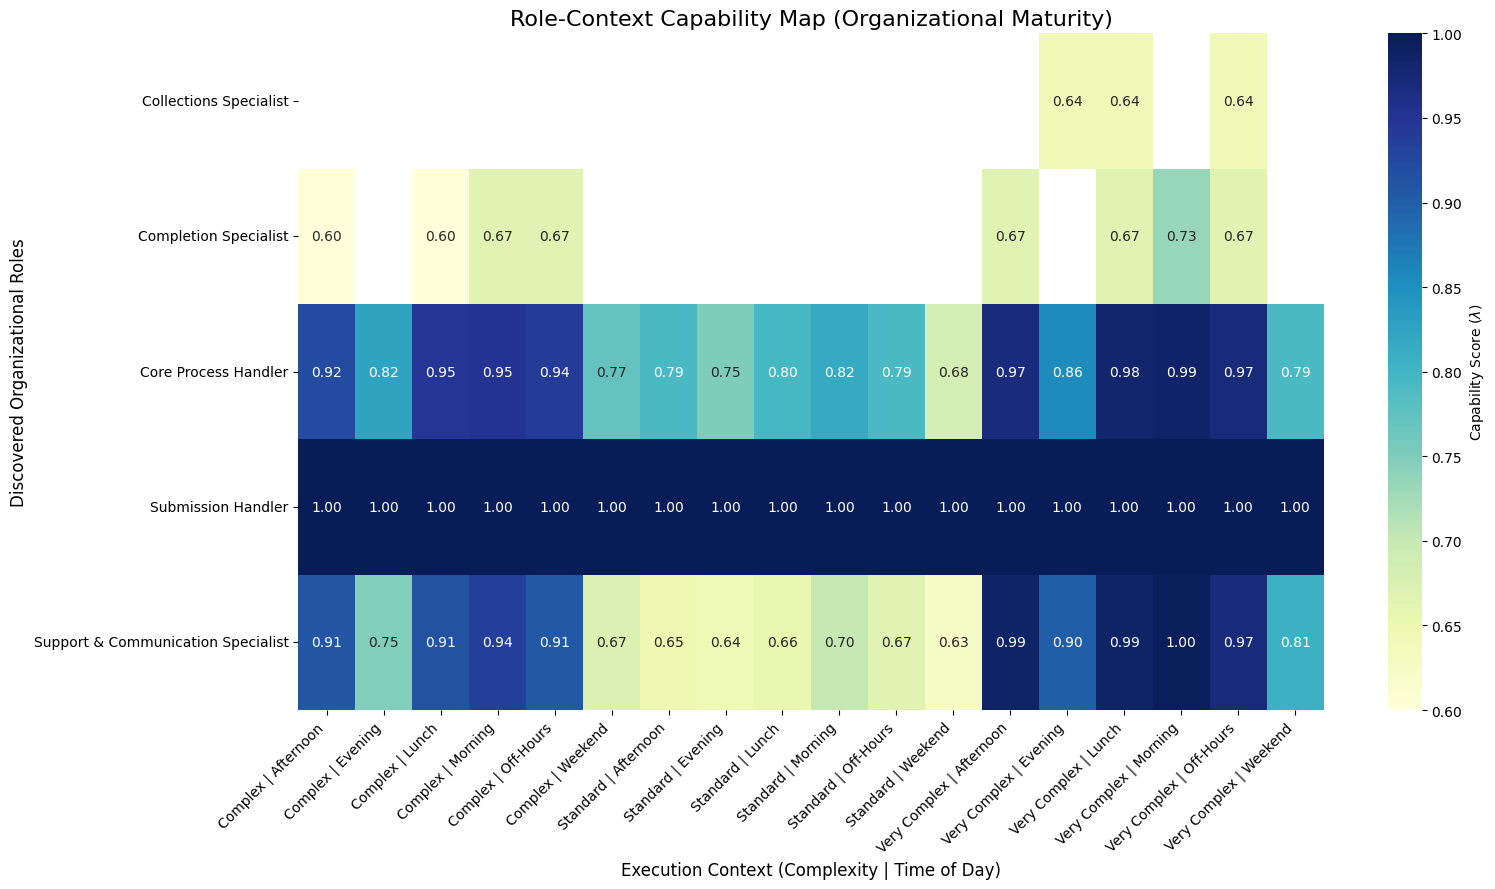

In [15]:
rp.plot_capability_heatmap(capabilities, role_names)